In [77]:
import pandas as pd

returns_dataframe = pd.read_csv('Data/long_short_returns_clean.csv', index_col='date')
returns = pd.DataFrame(returns_dataframe['long_short_return'])

hhi = pd.read_pickle('Data/HHI.pkl')
hhi_series = hhi.pivot(index='date', columns='industry', values='HHI')

returns = returns.squeeze()
returns.index = pd.to_datetime(returns.index)
returns.index = returns.index.to_period('M').to_timestamp('M')
mktcap = hhi.pivot(index='date', columns='industry', values='Industry_MktCap')

pb_short = pd.read_pickle("Data/pb_short.pkl")

price_short = pd.read_pickle("Data/price_short.pkl")
bv_short = pd.read_pickle("Data/bv_short.pkl")
div_short = pd.read_pickle("Data/div_short.pkl")

bv_long = pd.read_pickle('Data/bv_long.pkl')
price_long = pd.read_pickle('Data/price_long.pkl')
div_long = pd.read_pickle('Data/div_long.pkl')

In [24]:
weights = mktcap.div(mktcap.sum(axis=1), axis=0)
vw_hhi = (hhi_series * weights).sum(axis=1)
vw_hhi.name = 'vw_hhi'
vw_hhi = vw_hhi.dropna()
vw_hhi.index = vw_hhi.index.to_period('M').to_timestamp('M')
vw_hhi.head()

date
1960-01-31    0.096311
1960-02-29    0.096763
1960-03-31    0.098573
1960-04-30    0.101176
1960-05-31    0.102688
Freq: ME, Name: vw_hhi, dtype: float64

In [32]:
df = pd.concat([returns, vw_hhi], axis=1).dropna()
df.columns = ['returns', 'vw_hhi']
df.head()

,returns,vw_hhi
date,,
1961-07-31,0.002714,0.101733
1961-08-31,-0.011972,0.102121
1961-09-30,0.001499,0.106440
1961-10-31,0.006040,0.110439
1961-11-30,0.010409,0.108132


<Axes: title={'center': 'Rolling Correlation (5 years)'}, xlabel='date'>

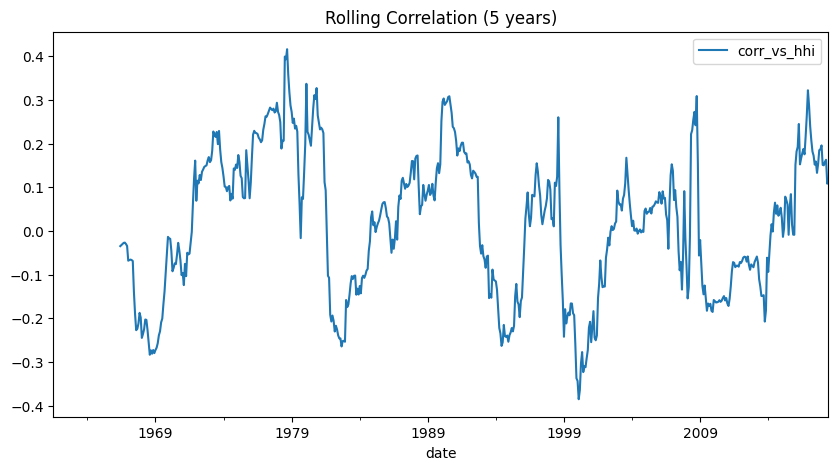

In [35]:
df['corr_vs_hhi'] = df['returns'].rolling(60).corr(df['vw_hhi'])
#df['corr_vs_etf'] = df['returns'].rolling(60).corr(df['etf_share'])

df[['corr_vs_hhi']].plot(title='Rolling Correlation (5 years)', figsize=(10,5))


In [152]:
#Preparing data
pb_short_cleaned = []
for entry in pb_short:
    date = entry['date']
    pb_series = entry['pb_short']
    if isinstance(pb_series, pd.Series):
        avg_pb = pb_series.mean()
    else:
        avg_pb = pb_series  # fallback in case it's already scalar
    pb_short_cleaned.append({'date': date, 'pb_short': avg_pb})

#Valuation Bubble Detection - Long Positions
pb_long = pd.read_pickle('Data/pb_long.pkl')

#Preparing data
pb_long_cleaned = []
for entry in pb_long:
    date = entry['date']
    pb_series = entry['pb_long']
    if isinstance(pb_series, pd.Series):
        avg_pb = pb_series.mean()
    else:
        avg_pb = pb_series  # fallback in case it's already scalar
    pb_long_cleaned.append({'date': date, 'pb_long': avg_pb})


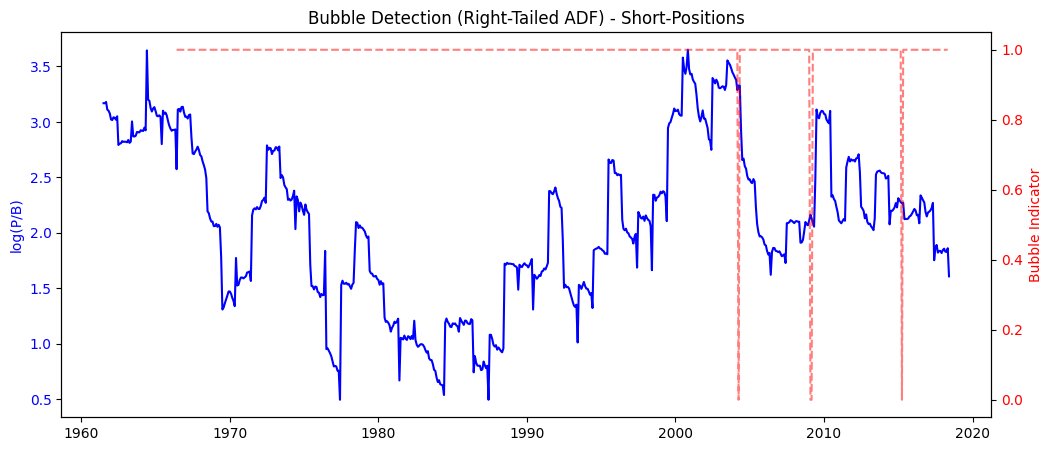

            adf_stat  crit_value_1pct  bubble_flag
date                                              
1966-06-01 -2.313839        -3.548494         True
1966-07-01 -2.857806        -3.548494         True
1966-08-01 -3.034974        -3.548494         True
1966-09-01 -3.020587        -3.548494         True
1966-10-01 -2.954451        -3.548494         True
...              ...              ...          ...
2018-01-01 -1.581578        -3.548494         True
2018-02-01 -1.593018        -3.548494         True
2018-03-01 -1.529575        -3.548494         True
2018-04-01 -1.399145        -3.548494         True
2018-05-01 -1.302740        -3.548494         True

[624 rows x 3 columns]


In [153]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

# === INPUT: time series of valuation metric, e.g., log(P/B) of growth stocks ===
# This should be a pd.Series with datetime index
# Example: log_pb = np.log(growth_portfolio_data['P/B'])

def rolling_adf_test(series, min_window=24):
    """
    Runs rolling ADF tests on a time series.
    Returns the ADF statistic and critical value at each step.
    """
    adf_stats = []
    crit_vals = []
    dates = []

    for start in range(0, len(series) - min_window):
        window = series.iloc[start:start + min_window]
        if window.isnull().any():
            adf_stats.append(np.nan)
            crit_vals.append(np.nan)
            dates.append(series.index[start + min_window - 1])
            continue
        
        adf_result = ts.adfuller(window, maxlag=1, regression='c', autolag=None)
        adf_stats.append(adf_result[0])
        crit_vals.append(adf_result[4]['1%'])  # right-tailed rejection at 1%
        dates.append(series.index[start + min_window - 1])

    results = pd.DataFrame({
        'date': dates,
        'adf_stat': adf_stats,
        'crit_value_1pct': crit_vals
    }).set_index('date')

    results['bubble_flag'] = results['adf_stat'] > results['crit_value_1pct']
    return results


pb_short_df = pd.DataFrame(pb_short_cleaned)
pb_short_df.set_index('date', inplace=True)
pb_short_df.index = pb_short_df.index.to_timestamp()

log_pb = np.log(pb_short_df["pb_short"]).dropna()



bubble_results = rolling_adf_test(log_pb, min_window=60)

# === Plot ===
def plot_bubble_detection(bubble_results, series, title='Bubble Detection (Right-Tailed ADF) - Short-Positions'):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    ax1.plot(series.index, series, label='Valuation Ratio', color='blue')
    ax1.set_ylabel('log(P/B)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Add bubble regions
    ax2 = ax1.twinx()
    ax2.plot(bubble_results.index, bubble_results['bubble_flag'].astype(int), 
             color='red', label='Bubble Indicator', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Bubble Indicator', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title(title)
    plt.show()

# === To run ===
plot_bubble_detection(bubble_results, log_pb)
print(bubble_results)


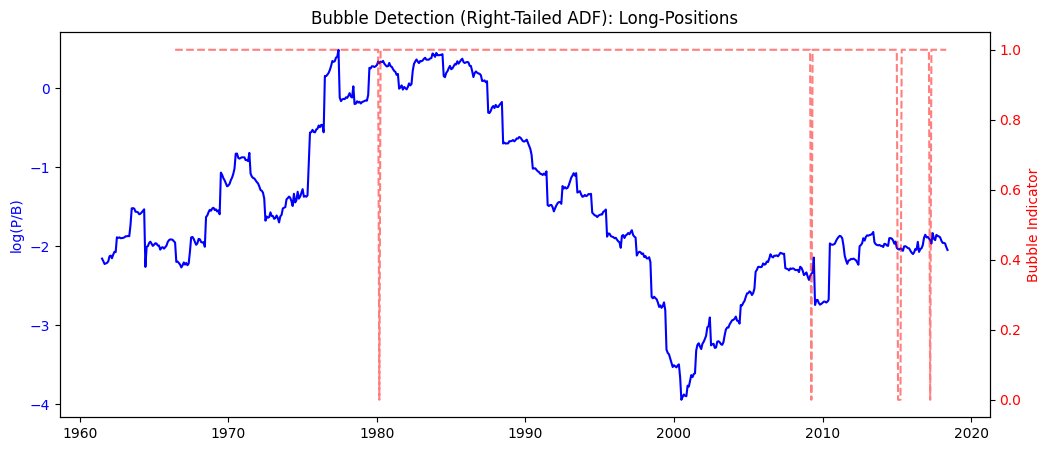

            adf_stat  crit_value_1pct  bubble_flag
date                                              
1966-06-01 -2.013458        -3.548494         True
1966-07-01 -1.979664        -3.548494         True
1966-08-01 -1.953608        -3.548494         True
1966-09-01 -1.910888        -3.548494         True
1966-10-01 -1.824906        -3.548494         True
...              ...              ...          ...
2018-01-01 -2.295309        -3.548494         True
2018-02-01 -2.454047        -3.548494         True
2018-03-01 -2.586917        -3.548494         True
2018-04-01 -2.874442        -3.548494         True
2018-05-01 -2.238897        -3.548494         True

[624 rows x 3 columns]


In [154]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

# === INPUT: time series of valuation metric, e.g., log(P/B) of growth stocks ===
# This should be a pd.Series with datetime index
# Example: log_pb = np.log(growth_portfolio_data['P/B'])

def rolling_adf_test(series, min_window=24):
    """
    Runs rolling ADF tests on a time series.
    Returns the ADF statistic and critical value at each step.
    """
    adf_stats = []
    crit_vals = []
    dates = []

    for start in range(0, len(series) - min_window):
        window = series.iloc[start:start + min_window]
        if window.isnull().any():
            adf_stats.append(np.nan)
            crit_vals.append(np.nan)
            dates.append(series.index[start + min_window - 1])
            continue
        
        adf_result = ts.adfuller(window, maxlag=1, regression='c', autolag=None)
        adf_stats.append(adf_result[0])
        crit_vals.append(adf_result[4]['1%'])  # right-tailed rejection at 1%
        dates.append(series.index[start + min_window - 1])

    results = pd.DataFrame({
        'date': dates,
        'adf_stat': adf_stats,
        'crit_value_1pct': crit_vals
    }).set_index('date')

    results['bubble_flag'] = results['adf_stat'] > results['crit_value_1pct']
    return results


pb_long_df = pd.DataFrame(pb_long_cleaned)
pb_long_df.set_index('date', inplace=True)
pb_long_df.index = pb_long_df.index.to_timestamp()

log_pb = np.log(pb_long_df["pb_long"]).dropna()



bubble_results = rolling_adf_test(log_pb, min_window=60)

# === Plot ===
def plot_bubble_detection(bubble_results, series, title='Bubble Detection (Right-Tailed ADF): Long-Positions'):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    ax1.plot(series.index, series, label='Valuation Ratio', color='blue')
    ax1.set_ylabel('log(P/B)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Add bubble regions
    ax2 = ax1.twinx()
    ax2.plot(bubble_results.index, bubble_results['bubble_flag'].astype(int), 
             color='red', label='Bubble Indicator', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Bubble Indicator', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title(title)
    plt.show()

# === To run ===
plot_bubble_detection(bubble_results, log_pb)
print(bubble_results)

                            OLS Regression Results                            
Dep. Variable:        log_price_short   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3604.
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           2.39e-57
Time:                        14:45:47   Log-Likelihood:                 33.123
No. Observations:                  56   AIC:                            -60.25
Df Residuals:                      53   BIC:                            -54.17
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0825      0.751      5.435   

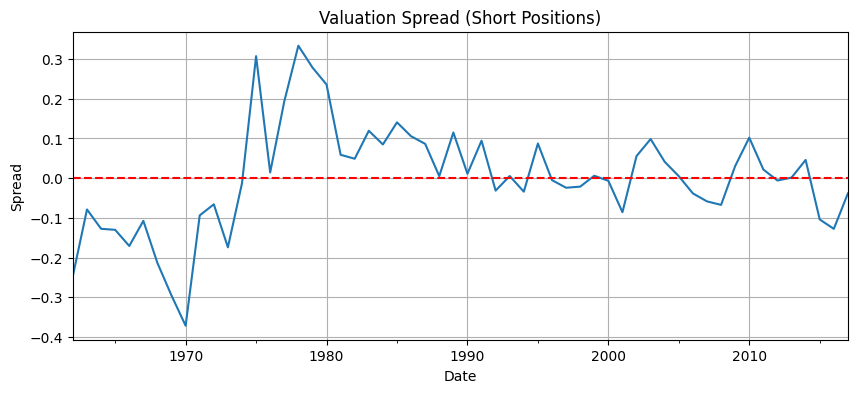

In [146]:
#Fundamentals vs Market Valuation Decomposition Short-Positions
import statsmodels.api as sm

"""
    The regression computes how much the market values the "intrinsic" value of a company (bookvalue).
    The results will be used to detect mispricings over time.

"""
log_price_short = np.log(price_short['avg_value'])
log_price_short.name = 'log_price_short'

log_bv_short = np.log(bv_short['avg_value'])
log_bv_short.name = 'log_bv_short'

#div_short = div_short['avg_value']
#div_short = pd.Series(div_short['avg_value'], name="div_short")
#div_short.name = 'div_short'

df_short = pd.concat([log_price_short, log_bv_short, div_short], axis=1, join="inner")

Y = df_short['log_price_short']
X = df_short[['log_bv_short', 'div_short']]
X_sm = sm.add_constant(X)

model_short = sm.OLS(Y, X_sm)
results_short = model_short.fit()
print(results_short.summary())

"""
    Valuation Spread
    Spread = log(P) - log(P_predicted)

    Positive Spread: Market price is above fundamentals -> potential overvaluation
    Negative Spread: Market price is below fundamentals -> potential undervaluation

"""


# Predicted log prices from the regression
df_short['predicted_log_price'] = results_short.fittedvalues

# Valuation spread: actual minus predicted
df_short['valuation_spread'] = df_short['log_price_short'] - df_short['predicted_log_price']

import matplotlib.pyplot as plt

df_short['valuation_spread'].plot(title="Valuation Spread (Short Positions)", figsize=(10, 4))
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.grid(True)
plt.show()




                            OLS Regression Results                            
Dep. Variable:         log_price_long   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     780.0
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           4.91e-40
Time:                        10:27:03   Log-Likelihood:                 1.1931
No. Observations:                  56   AIC:                             3.614
Df Residuals:                      53   BIC:                             9.690
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.4677      0.776      9.617      

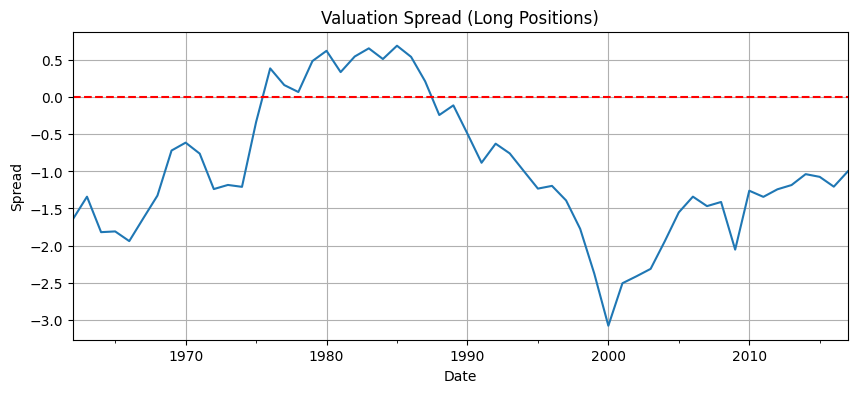

In [155]:
#Fundamentals vs Market Valuation Decomposition Short-Positions
import statsmodels.api as sm

"""
    The regression computes how much the market values the "intrinsic" value of a company (bookvalue).
    The results will be used to detect mispricings over time.

"""
log_price_long = np.log(price_long['avg_value'])
log_price_long.name = 'log_price_long'

log_bv_long = np.log(bv_long['avg_value'])
log_bv_long.name = 'log_bv_long'

#div_short = div_short['avg_value']
div_long_series = pd.Series(div_long['avg_value'], name="div_long")
#div_short.name = 'div_short'

df_long = pd.concat([log_price_long, log_bv_long, div_long_series], axis=1, join="inner")

Y = df_long['log_price_long']
X = df_long[['log_bv_long', 'div_long']]
X_sm = sm.add_constant(X)

model_long = sm.OLS(Y, X_sm)
results_long = model_long.fit()
print(results_long.summary())

"""
    Valuation Spread
    Spread = log(P) - log(P_predicted)

    Positive Spread: Market price is above fundamentals -> potential overvaluation
    Negative Spread: Market price is below fundamentals -> potential undervaluation

"""


# Predicted log prices from the regression
df_long['predicted_log_price'] = results_long.fittedvalues

# Valuation spread: actual minus predicted
df_long['valuation_spread'] = df_long['log_price_long'] - df_short['predicted_log_price']

import matplotlib.pyplot as plt

df_long['valuation_spread'].plot(title="Valuation Spread (Long Positions)", figsize=(10, 4))
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.grid(True)
plt.show()




In [150]:
print("Avg spread (value/long):", df_long['valuation_spread'].mean())
print("Avg spread (growth/short):", df_short['valuation_spread'].mean())


Avg spread (value/long): -0.9611348572231753
Avg spread (growth/short): -3.536928755844469e-06


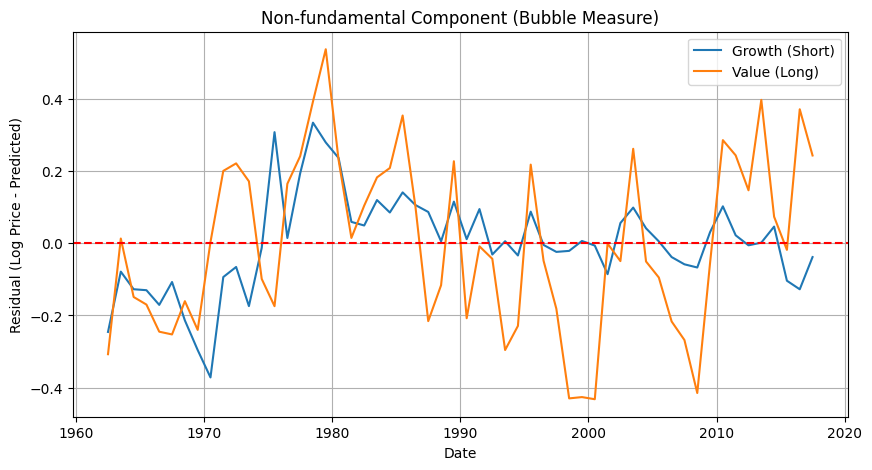

In [141]:
import matplotlib.pyplot as plt

""" 
    Analyzing the part of an assets price which is not explained by fundamentals.

    The residual reflects the part of price not explained by fundamentals (book value + dividends).
    Positive residual → price above fundamental value → possible overvaluation.
    Negative residual → price below fundamental value → possible undervaluation.   

"""

plt.figure(figsize=(10, 5))

plt.plot(df_short.index, df_short['residual'], label='Growth (Short)')
plt.plot(df_long.index, df_long['residual'], label='Value (Long)')
plt.axhline(0, color='red', linestyle='--')
plt.title("Non-fundamental Component (Bubble Measure)")
plt.xlabel("Date")
plt.ylabel("Residual (Log Price - Predicted)")
plt.legend()
plt.grid(True)
plt.show()


Cointegration Tests:

Objective: to assess, wheather or not price and bookvalue are cointegrated (both time-series are non-stationary by themselves, but share a stationary spread)

This will be used to further analyze bubble existance.

In [130]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_short['residual'].dropna())
print('==============================================================')
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

score, pvalue, _ = coint(df_short['log_price_short'], df_short['log_bv_short'])
print(f"Cointegration p-value: {pvalue}")

from statsmodels.tsa.vector_ar.vecm import coint_johansen
data_short = df_short[['log_price_short','log_bv_short']]
jres = coint_johansen(data_short, det_order=-1, k_ar_diff=1)

# Results:
print('==============================================================')
print("Eigenvalues:", jres.eig)
print('--------------------------------------------------------------')
print("Trace statistic:", jres.lr1)         # Trace test statistics
print('--------------------------------------------------------------')
print("Critical values (90%, 95%, 99%):", jres.cvt)  # Critical values for trace test
print('--------------------------------------------------------------')
print("Max-eigen statistic:", jres.lr2)     # Max eigenvalue statistics
print('--------------------------------------------------------------')
print("Critical values for max-eigen:", jres.cvm)
print('==============================================================')
print('')
print('')
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM

# Your dataframe with columns, e.g. 'log_price_short', 'log_bv_short', 'div_short'
# Make sure it is a pandas DataFrame with no missing values and proper datetime index
#print(data.tail())

vecm = VECM(data_short, k_ar_diff=1, coint_rank=1, deterministic='ci')  # 'ci' means constant in cointegration relation
vecm_res = vecm.fit()
print(vecm_res.summary())

ADF Statistic: -3.509905747239283
p-value: 0.007736308198261543
Cointegration p-value: 0.05287425273145603
Eigenvalues: [0.09444619 0.03190403]
--------------------------------------------------------------
Trace statistic: [7.10816263 1.75089917]
--------------------------------------------------------------
Critical values (90%, 95%, 99%): [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
--------------------------------------------------------------
Max-eigen statistic: [5.35726345 1.75089917]
--------------------------------------------------------------
Critical values for max-eigen: [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]


Det. terms outside the coint. relation & lagged endog. parameters for equation log_price_short
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.log_price_short     0.0831      0.313      0.266      0.791      -0.53

Johannsens Cointegration Test:

Price corrects a change in the log bookvalue of the short position by 45.87% in the first period

In [100]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_long['residual'].dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

score, pvalue, _ = coint(df_long['log_price_long'], df_long['log_bv_long'])
print(f"Cointegration p-value: {pvalue}")

ADF Statistic: -1.542429222450908
p-value: 0.5124276396791531
Cointegration p-value: 0.6425552198473904


In [101]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
data_long = df_long[['log_price_long','log_bv_long']]
jres = coint_johansen(data_long, det_order=-1, k_ar_diff=1)

# Results:
print("Eigenvalues:", jres.eig)
print("Trace statistic:", jres.lr1)         # Trace test statistics
print("Critical values (90%, 95%, 99%):", jres.cvt)  # Critical values for trace test
print("Max-eigen statistic:", jres.lr2)     # Max eigenvalue statistics
print("Critical values for max-eigen:", jres.cvm)

Eigenvalues: [0.11418501 0.05525293]
Trace statistic: [9.61660053 3.06925387]
Critical values (90%, 95%, 99%): [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
Max-eigen statistic: [6.54734666 3.06925387]
Critical values for max-eigen: [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]


In [102]:
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM

# Your dataframe with columns, e.g. 'log_price_short', 'log_bv_short', 'div_short'
# Make sure it is a pandas DataFrame with no missing values and proper datetime index
#print(data.tail())

vecm_long = VECM(data_long, k_ar_diff=1, coint_rank=1, deterministic='ci')  # 'ci' means constant in cointegration relation
vecm_res_long = vecm_long.fit()
print(vecm_res_long.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation log_price_long
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.log_price_long     0.3355      0.293      1.145      0.252      -0.239       0.910
L1.log_bv_long       -0.3060      0.202     -1.511      0.131      -0.703       0.091
Det. terms outside the coint. relation & lagged endog. parameters for equation log_bv_long
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.log_price_long     0.3624      0.429      0.845      0.398      -0.479       1.203
L1.log_bv_long       -0.3462      0.296     -1.168      0.243      -0.927       0.235
           Loading coefficients (alpha) for equation log_price_long           
                 coef    std err          z     

Johannsens Cointegration Test:

Price scales a change in the log bookvalue of the short position by 17.12% in the first period

Regime Analysis:

A Markov-Regression will be used to pinpoint structural breaks in the time-series. These can point out different regimes in the market over time.

In [118]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Assuming `df` is your DataFrame and contains `log_price_short`
# Convert to numpy array and drop NaNs
y_short = df_short['log_price_short'].dropna().values
y_scaled_short = (y_short - y_short.mean()) / y_short.std()
#returns.index = returns.index.to_timestamp()
"""X = sm.add_constant(df[['log_bv_short']].dropna())
model = MarkovRegression(y_scaled, k_regimes=2, exog=X, trend='c', switching_variance=True)"""


# Fit a 2-regime Markov switching autoregressive model (AR(1) with regime switching)
model_short = MarkovRegression(y_scaled_short, k_regimes=2, trend='c', switching_variance=True)
res_short = model_short.fit()

# Print summary
print(res_short.summary())


                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                   56
Model:               MarkovRegression   Log Likelihood                 -24.065
Date:                Thu, 26 Jun 2025   AIC                             60.131
Time:                        14:27:55   BIC                             72.283
Sample:                             0   HQIC                            64.842
                                 - 56                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6787      0.102     -6.669      0.000      -0.878      -0.479
sigma2         0.3288      0.087      3.763      0.0

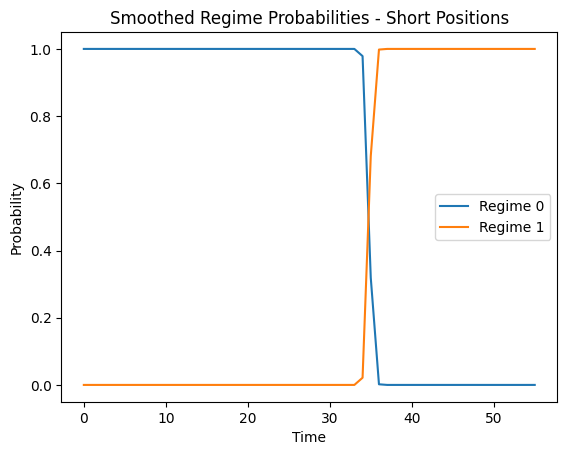

In [119]:
import matplotlib.pyplot as plt

probs_short = res_short.smoothed_marginal_probabilities

# If DataFrame
if hasattr(probs_short, 'iloc'):
    plt.plot(probs_short.iloc[:, 0], label='Regime 0')
    plt.plot(probs_short.iloc[:, 1], label='Regime 1')
else:  # If numpy array
    plt.plot(probs_short[:, 0], label='Regime 0')
    plt.plot(probs_short[:, 1], label='Regime 1')

plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Smoothed Regime Probabilities - Short Positions')
plt.legend()
plt.show()



In [121]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Assuming `df` is your DataFrame and contains `log_price_short`
# Convert to numpy array and drop NaNs
y_long = df_long['log_price_long'].dropna().values
y_scaled_long = (y_long - y_long.mean()) / y_long.std()
#returns.index = returns.index.to_timestamp()
"""X = sm.add_constant(df[['log_bv_short']].dropna())
model = MarkovRegression(y_scaled, k_regimes=2, exog=X, trend='c', switching_variance=True)"""


# Fit a 2-regime Markov switching autoregressive model (AR(1) with regime switching)
model_long = MarkovRegression(y_scaled_long, k_regimes=2, trend='c', switching_variance=True)
res_long = model_long.fit()

# Print summary
print(res_long.summary())


                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                   56
Model:               MarkovRegression   Log Likelihood                 -55.860
Date:                Thu, 26 Jun 2025   AIC                            123.719
Time:                        14:28:58   BIC                            135.871
Sample:                             0   HQIC                           128.431
                                 - 56                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3449      0.039      8.809      0.000       0.268       0.422
sigma2         0.0291      0.010      2.883      0.0

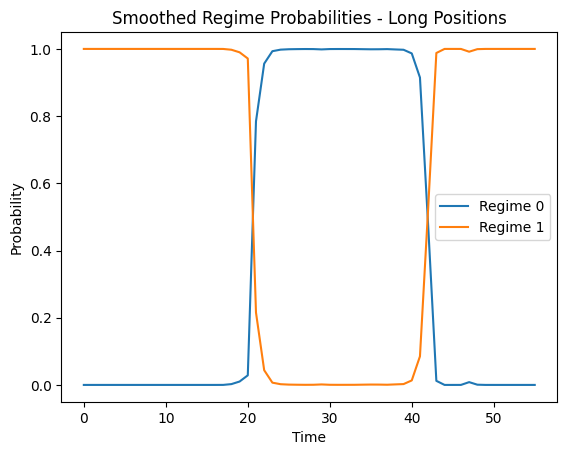

In [122]:
import matplotlib.pyplot as plt

probs_long = res_long.smoothed_marginal_probabilities

# If DataFrame
if hasattr(probs_long, 'iloc'):
    plt.plot(probs_long.iloc[:, 0], label='Regime 0')
    plt.plot(probs_long.iloc[:, 1], label='Regime 1')
else:  # If numpy array
    plt.plot(probs_long[:, 0], label='Regime 0')
    plt.plot(probs_long[:, 1], label='Regime 1')

plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Smoothed Regime Probabilities - Long Positions')
plt.legend()
plt.show()


Shiller CAPE: Cyclically Adjusted Price-to-Earnings ratio

Used to assess whether the stock market is over- or undervalued relative to long-term fundamentals.

- Traditional P/E ratios can be distorted by temporary earnings booms or recessions.
- CAPE filters out short-term noise, providing a long-term view of valuation.
- A high CAPE suggests markets are expensive → possibly lower future returns.
- A low CAPE suggests undervaluation → possibly higher long-term returns.

In [115]:
cape = pd.read_csv("Data/Shiller-CAPE.csv", delimiter=";", index_col="Date")
cape['Shiller CAPE'] = cape['Shiller CAPE'].str.replace(',', '.').astype(float)
cape.index = pd.to_datetime(cape.index)
cape.index = cape.index.to_period('M').to_timestamp('M')

In [114]:
#Shiller CAPE
import pandas as pd
import numpy as np


returns_df = pd.DataFrame(returns)
returns_df.index.name = "Date"

data = pd.concat([returns, cape], axis=1, join='inner')
data.rename(columns={"Shiller CAPE": "cape"}, inplace=True)
data.rename(columns={"long_short_return": "hml"}, inplace=True)



Performance by CAPE regime:
                 mean       std  count    sharpe
cape_regime                                     
High CAPE    0.005353  0.027879    342  0.192026
Low CAPE     0.002736  0.021500    342  0.127245


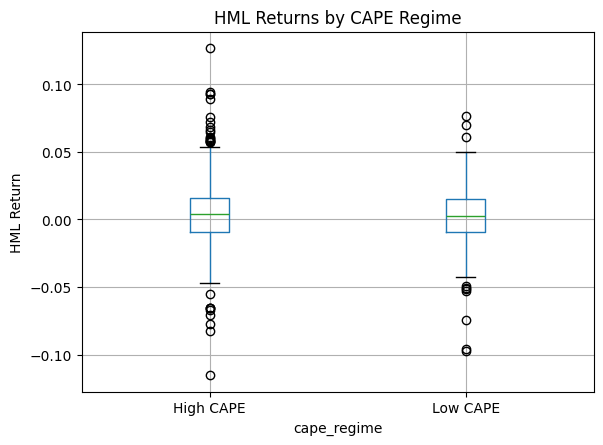

In [111]:
# Define high and low CAPE regimes
cape_median = data['cape'].median()
data['cape_regime'] = np.where(data['cape'] <= cape_median, 'Low CAPE', 'High CAPE')
# Group by CAPE regime
grouped = data.groupby('cape_regime')

# Calculate mean, std, and Sharpe ratio
results = grouped['hml'].agg(['mean', 'std', 'count'])
results['sharpe'] = results['mean'] / results['std']

print("Performance by CAPE regime:")
print(results)

import matplotlib.pyplot as plt

# Boxplot of returns by CAPE regime
data.boxplot(column='hml', by='cape_regime')
plt.title("HML Returns by CAPE Regime")
plt.suptitle('')
plt.ylabel("HML Return")
plt.show()


In [112]:
import statsmodels.api as sm

# Create dummy for High CAPE regime
data['high_cape_dummy'] = np.where(data['cape_regime'] == 'High CAPE', 1, 0)

# Regression: HML ~ High CAPE dummy
X = sm.add_constant(data['high_cape_dummy'])
y = data['hml']
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    hml   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.891
Date:                Thu, 26 Jun 2025   Prob (F-statistic):              0.170
Time:                        14:16:25   Log-Likelihood:                 1556.5
No. Observations:                 684   AIC:                            -3109.
Df Residuals:                     682   BIC:                            -3100.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0027      0.001     

In [113]:
from scipy.stats import ttest_ind

low_cape_returns = data[data['cape_regime'] == 'Low CAPE']['hml']
high_cape_returns = data[data['cape_regime'] == 'High CAPE']['hml']

t_stat, p_val = ttest_ind(low_cape_returns, high_cape_returns, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")


T-statistic: -1.375, p-value: 0.170


Interpretation of Shiller CAPE decomposition of HML returns:
The Boxplot shows that the median return is slightly higher in a high CAPE environment. The major difference is in the volatility. In high CAPE regimes, the volatility/spread is significantly larger than in low CAPE regimes.

An OLS regression could not show that returns are significantly higher in high CAPE environments and a t-Test could not show that the returns differ at all.

Running comprehensive value cycle analysis...
VALUE FACTOR CYCLICAL FLOW ANALYSIS REPORT

1. MEAN REVERSION TESTS
------------------------------
Augmented Dickey-Fuller Test:
  Statistic: -6.3944
  P-value: 0.0000
  Is Stationary (Mean Reverting): True

Variance Ratios (< 1 suggests mean reversion):
  12_month: 7.9709
  24_month: 11.4029
  36_month: 12.8357
  60_month: 13.2526

Autocorrelations (negative suggests mean reversion):
  lag_1: 0.8866 (p=0.000)*
  lag_3: 0.6967 (p=0.000)*
  lag_6: 0.4950 (p=0.000)*
  lag_12: 0.2660 (p=0.000)*
  lag_24: 0.0003 (p=0.994)

2. CONTRARIAN STRATEGY TESTS
------------------------------
Best contrarian strategies (negative correlation = mean reversion):
  lookback_36_forward_12:
    Correlation: 0.1943
    Regression coef: 0.0859 (p=0.000)*
    Quintile spread: 0.2294
  lookback_36_forward_6:
    Correlation: 0.2608
    Regression coef: 0.0641 (p=0.000)*
    Quintile spread: 0.2068
  lookback_24_forward_12:
    Correlation: 0.2835
    Regression coe

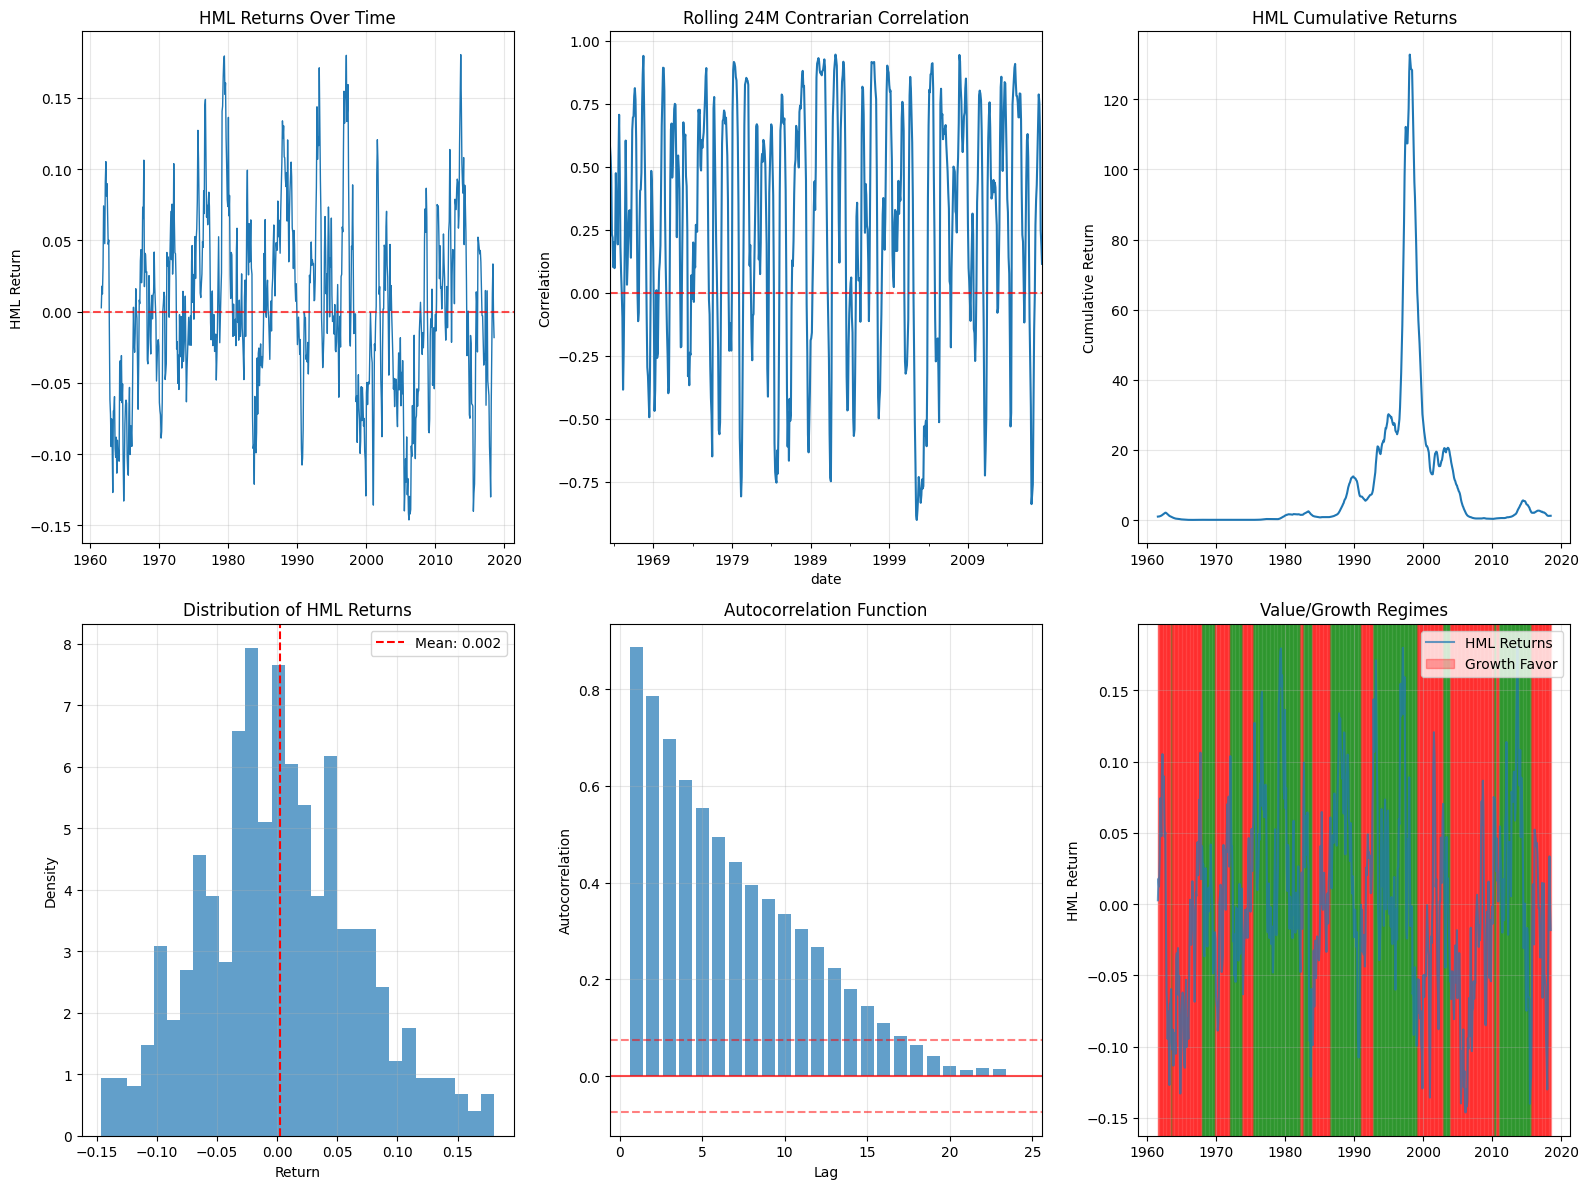

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

class ValueCycleTester:
    """
    Comprehensive testing framework for value factor cyclical flows hypothesis
    """
    
    def __init__(self, hml_returns, value_spread=None, flows_data=None):
        """
        Initialize with HML returns and optional supporting data
        
        Parameters:
        hml_returns: pandas Series of HML factor returns
        value_spread: pandas Series of value vs growth valuation spread (optional)
        flows_data: pandas DataFrame with value/growth fund flows (optional)
        """
        self.hml_returns = hml_returns
        self.value_spread = value_spread
        self.flows_data = flows_data
        self.results = {}
        
    def test_mean_reversion(self, lookback_periods=[12, 24, 36, 60]):
        """
        Test mean reversion in HML returns using multiple approaches
        """
        results = {}
        
        # 1. Augmented Dickey-Fuller test for stationarity/mean reversion
        adf_stat, adf_pvalue, _, _, adf_critical, _ = adfuller(self.hml_returns.dropna())
        results['adf_test'] = {
            'statistic': adf_stat,
            'p_value': adf_pvalue,
            'critical_values': adf_critical,
            'is_stationary': adf_pvalue < 0.05
        }
        
        # 2. Variance ratio tests for mean reversion
        variance_ratios = {}
        for period in lookback_periods:
            if len(self.hml_returns) > period * 2:
                # Calculate variance ratio
                var_1 = self.hml_returns.var()
                var_k = self.hml_returns.rolling(period).sum().var() / period
                variance_ratios[f'{period}_month'] = var_k / var_1
        
        results['variance_ratios'] = variance_ratios
        
        # 3. Autocorrelation test
        autocorr_results = {}
        for lag in [1, 3, 6, 12, 24]:
            if len(self.hml_returns) > lag:
                autocorr = self.hml_returns.autocorr(lag)
                # Test significance
                n = len(self.hml_returns.dropna())
                se = 1 / np.sqrt(n)
                t_stat = autocorr / se
                p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
                
                autocorr_results[f'lag_{lag}'] = {
                    'correlation': autocorr,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                }
        
        results['autocorrelation'] = autocorr_results
        
        self.results['mean_reversion'] = results
        return results
    
    def test_contrarian_strategy(self, lookback_periods=[12, 24, 36], 
                                forward_periods=[1, 3, 6, 12]):
        """
        Test if poor past performance predicts good future performance (contrarian effect)
        """
        results = {}
        
        for lookback in lookback_periods:
            for forward in forward_periods:
                if len(self.hml_returns) > lookback + forward:
                    # Calculate rolling past performance
                    past_performance = self.hml_returns.rolling(lookback).sum()
                    
                    # Calculate forward returns
                    future_returns = self.hml_returns.rolling(forward).sum().shift(-forward)
                    
                    # Remove NaN values
                    valid_data = pd.DataFrame({
                        'past': past_performance,
                        'future': future_returns
                    }).dropna()
                    
                    if len(valid_data) > 10:
                        # Test correlation (should be negative for mean reversion)
                        correlation = valid_data['past'].corr(valid_data['future'])
                        
                        # Regression test
                        X = sm.add_constant(valid_data['past'])
                        model = sm.OLS(valid_data['future'], X).fit()
                        
                        # Quintile analysis
                        valid_data['quintile'] = pd.qcut(valid_data['past'], 5, labels=False)
                        quintile_returns = valid_data.groupby('quintile')['future'].mean()
                        
                        results[f'lookback_{lookback}_forward_{forward}'] = {
                            'correlation': correlation,
                            'regression_coef': model.params.iloc[1],
                            'regression_pvalue': model.pvalues.iloc[1],
                            'quintile_spread': quintile_returns.iloc[-1] - quintile_returns.iloc[0],
                            'bottom_quintile_return': quintile_returns.iloc[0],
                            'top_quintile_return': quintile_returns.iloc[-1]
                        }
        
        self.results['contrarian_strategy'] = results
        return results
    
    def test_valuation_spread_relationship(self):
        """
        Test relationship between HML returns and valuation spreads
        """
        if self.value_spread is None:
            print("No valuation spread data provided")
            return None
        
        results = {}
        
        # Align data
        aligned_data = pd.DataFrame({
            'hml_returns': self.hml_returns,
            'value_spread': self.value_spread
        }).dropna()
        
        if len(aligned_data) < 10:
            print("Insufficient overlapping data")
            return None
        
        # 1. Contemporaneous relationship
        contemp_corr = aligned_data['hml_returns'].corr(aligned_data['value_spread'])
        
        # 2. Lead-lag relationships
        lead_lag_results = {}
        for lag in [-12, -6, -3, -1, 0, 1, 3, 6, 12]:
            if abs(lag) < len(aligned_data):
                if lag == 0:
                    corr = contemp_corr
                elif lag > 0:
                    # HML returns lead valuation spread
                    corr = aligned_data['hml_returns'].corr(aligned_data['value_spread'].shift(lag))
                else:
                    # Valuation spread leads HML returns
                    corr = aligned_data['hml_returns'].shift(-lag).corr(aligned_data['value_spread'])
                
                lead_lag_results[f'lag_{lag}'] = corr
        
        # 3. Regime analysis based on valuation spreads
        spread_quintiles = pd.qcut(aligned_data['value_spread'], 5, labels=False)
        regime_returns = aligned_data.groupby(spread_quintiles)['hml_returns'].agg(['mean', 'std', 'count'])
        
        # 4. Cointegration test (if enough data)
        if len(aligned_data) > 50:
            try:
                coint_stat, coint_pvalue, _ = coint(aligned_data['hml_returns'].cumsum(), 
                                                  aligned_data['value_spread'])
                cointegration = {
                    'statistic': coint_stat,
                    'p_value': coint_pvalue,
                    'is_cointegrated': coint_pvalue < 0.05
                }
            except:
                cointegration = None
        else:
            cointegration = None
        
        results = {
            'contemporaneous_correlation': contemp_corr,
            'lead_lag_correlations': lead_lag_results,
            'regime_analysis': regime_returns,
            'cointegration': cointegration
        }
        
        self.results['valuation_spread'] = results
        return results
    
    def test_flow_performance_relationship(self):
        """
        Test relationship between flows and performance
        """
        if self.flows_data is None:
            print("No flows data provided")
            return None
        
        results = {}
        
        # Assume flows_data has columns: 'value_flows', 'growth_flows'
        if 'value_flows' not in self.flows_data.columns:
            print("Expected 'value_flows' column in flows_data")
            return None
        
        # Calculate relative flows (value minus growth)
        if 'growth_flows' in self.flows_data.columns:
            relative_flows = self.flows_data['value_flows'] - self.flows_data['growth_flows']
        else:
            relative_flows = self.flows_data['value_flows']
        
        # Align with HML returns
        aligned_data = pd.DataFrame({
            'hml_returns': self.hml_returns,
            'flows': relative_flows
        }).dropna()
        
        if len(aligned_data) < 10:
            print("Insufficient overlapping data")
            return None
        
        # 1. Performance -> Flows relationship
        perf_to_flows = {}
        for lag in [1, 3, 6, 12]:
            if len(aligned_data) > lag:
                past_returns = aligned_data['hml_returns'].rolling(lag).sum()
                future_flows = aligned_data['flows'].shift(-1)  # Next period flows
                
                valid_data = pd.DataFrame({'returns': past_returns, 'flows': future_flows}).dropna()
                if len(valid_data) > 5:
                    correlation = valid_data['returns'].corr(valid_data['flows'])
                    
                    # Regression
                    X = sm.add_constant(valid_data['returns'])
                    model = sm.OLS(valid_data['flows'], X).fit()
                    
                    perf_to_flows[f'{lag}_month_returns'] = {
                        'correlation': correlation,
                        'regression_coef': model.params.iloc[1],
                        'regression_pvalue': model.pvalues.iloc[1],
                        'r_squared': model.rsquared
                    }
        
        # 2. Flows -> Performance relationship
        flows_to_perf = {}
        for lag in [1, 3, 6, 12]:
            if len(aligned_data) > lag:
                past_flows = aligned_data['flows'].rolling(lag).sum()
                future_returns = aligned_data['hml_returns'].shift(-1)  # Next period returns
                
                valid_data = pd.DataFrame({'flows': past_flows, 'returns': future_returns}).dropna()
                if len(valid_data) > 5:
                    correlation = valid_data['flows'].corr(valid_data['returns'])
                    
                    # Regression
                    X = sm.add_constant(valid_data['flows'])
                    model = sm.OLS(valid_data['returns'], X).fit()
                    
                    flows_to_perf[f'{lag}_month_flows'] = {
                        'correlation': correlation,
                        'regression_coef': model.params.iloc[1],
                        'regression_pvalue': model.pvalues.iloc[1],
                        'r_squared': model.rsquared
                    }
        
        results = {
            'performance_to_flows': perf_to_flows,
            'flows_to_performance': flows_to_perf
        }
        
        self.results['flow_performance'] = results
        return results
    
    def identify_regimes(self, method='rolling_mean', window=24, threshold=0):
        """
        Identify value favor vs growth favor regimes
        """
        if method == 'rolling_mean':
            signal = self.hml_returns.rolling(window).mean()
            regimes = (signal > threshold).astype(int)
        elif method == 'cumulative':
            signal = self.hml_returns.cumsum()
            regimes = (signal > signal.rolling(window).mean()).astype(int)
        else:
            raise ValueError("Method must be 'rolling_mean' or 'cumulative'")
        
        # Calculate regime statistics
        regime_stats = {}
        for regime in [0, 1]:
            regime_data = self.hml_returns[regimes == regime]
            if len(regime_data) > 0:
                regime_stats[f'regime_{regime}'] = {
                    'mean_return': regime_data.mean(),
                    'volatility': regime_data.std(),
                    'periods': len(regime_data),
                    'percentage': len(regime_data) / len(self.hml_returns) * 100
                }
        
        # Transition matrix
        transitions = pd.crosstab(regimes, regimes.shift(1), normalize='index')
        
        # Persistence (probability of staying in same regime)
        persistence = {
            'regime_0': transitions.loc[0, 0] if 0 in transitions.index and 0 in transitions.columns else np.nan,
            'regime_1': transitions.loc[1, 1] if 1 in transitions.index and 1 in transitions.columns else np.nan
        }
        
        results = {
            'regimes': regimes,
            'regime_statistics': regime_stats,
            'transition_matrix': transitions,
            'persistence': persistence
        }
        
        self.results['regime_analysis'] = results
        return results
    
    def generate_comprehensive_report(self):
        """
        Generate a comprehensive report of all tests
        """
        if not self.results:
            print("No tests have been run. Please run individual tests first.")
            return
        
        print("=" * 60)
        print("VALUE FACTOR CYCLICAL FLOW ANALYSIS REPORT")
        print("=" * 60)
        
        # Mean Reversion Tests
        if 'mean_reversion' in self.results:
            print("\n1. MEAN REVERSION TESTS")
            print("-" * 30)
            
            mr = self.results['mean_reversion']
            
            # ADF Test
            print(f"Augmented Dickey-Fuller Test:")
            print(f"  Statistic: {mr['adf_test']['statistic']:.4f}")
            print(f"  P-value: {mr['adf_test']['p_value']:.4f}")
            print(f"  Is Stationary (Mean Reverting): {mr['adf_test']['is_stationary']}")
            
            # Variance Ratios
            print(f"\nVariance Ratios (< 1 suggests mean reversion):")
            for period, ratio in mr['variance_ratios'].items():
                print(f"  {period}: {ratio:.4f}")
            
            # Autocorrelations
            print(f"\nAutocorrelations (negative suggests mean reversion):")
            for lag, data in mr['autocorrelation'].items():
                significance = "*" if data['significant'] else ""
                print(f"  {lag}: {data['correlation']:.4f} (p={data['p_value']:.3f}){significance}")
        
        # Contrarian Strategy Tests
        if 'contrarian_strategy' in self.results:
            print("\n2. CONTRARIAN STRATEGY TESTS")
            print("-" * 30)
            
            cs = self.results['contrarian_strategy']
            
            print("Best contrarian strategies (negative correlation = mean reversion):")
            sorted_strategies = sorted(cs.items(), key=lambda x: x[1]['correlation'])
            
            for i, (strategy, data) in enumerate(sorted_strategies[:5]):
                significance = "*" if data['regression_pvalue'] < 0.05 else ""
                print(f"  {strategy}:")
                print(f"    Correlation: {data['correlation']:.4f}")
                print(f"    Regression coef: {data['regression_coef']:.4f} (p={data['regression_pvalue']:.3f}){significance}")
                print(f"    Quintile spread: {data['quintile_spread']:.4f}")
        
        # Valuation Spread Tests
        if 'valuation_spread' in self.results:
            print("\n3. VALUATION SPREAD ANALYSIS")
            print("-" * 30)
            
            vs = self.results['valuation_spread']
            
            print(f"Contemporaneous correlation: {vs['contemporaneous_correlation']:.4f}")
            
            print("\nLead-lag correlations:")
            for lag, corr in vs['lead_lag_correlations'].items():
                print(f"  {lag}: {corr:.4f}")
            
            if vs['cointegration']:
                print(f"\nCointegration test:")
                print(f"  Statistic: {vs['cointegration']['statistic']:.4f}")
                print(f"  P-value: {vs['cointegration']['p_value']:.4f}")
                print(f"  Is Cointegrated: {vs['cointegration']['is_cointegrated']}")
        
        # Flow-Performance Tests
        if 'flow_performance' in self.results:
            print("\n4. FLOW-PERFORMANCE RELATIONSHIP")
            print("-" * 30)
            
            fp = self.results['flow_performance']
            
            print("Performance -> Flows (positive = flows follow performance):")
            for period, data in fp['performance_to_flows'].items():
                significance = "*" if data['regression_pvalue'] < 0.05 else ""
                print(f"  {period}: corr={data['correlation']:.4f}, coef={data['regression_coef']:.4f}{significance}")
            
            print("\nFlows -> Performance (negative = flows contrarian signal):")
            for period, data in fp['flows_to_performance'].items():
                significance = "*" if data['regression_pvalue'] < 0.05 else ""
                print(f"  {period}: corr={data['correlation']:.4f}, coef={data['regression_coef']:.4f}{significance}")
        
        # Regime Analysis
        if 'regime_analysis' in self.results:
            print("\n5. REGIME ANALYSIS")
            print("-" * 30)
            
            ra = self.results['regime_analysis']
            
            print("Regime statistics:")
            for regime, stats in ra['regime_statistics'].items():
                print(f"  {regime} ({stats['percentage']:.1f}% of time):")
                print(f"    Mean return: {stats['mean_return']:.4f}")
                print(f"    Volatility: {stats['volatility']:.4f}")
            
            print(f"\nRegime persistence:")
            for regime, persistence in ra['persistence'].items():
                if not np.isnan(persistence):
                    print(f"  {regime}: {persistence:.2%}")
        
        print("\n" + "=" * 60)
        print("* indicates statistical significance at 5% level")
    
    def plot_analysis_results(self, figsize=(16, 12)):
        """
        Create comprehensive visualization of analysis results
        """
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Plot 1: HML returns over time
        axes[0, 0].plot(self.hml_returns.index, self.hml_returns.values, linewidth=1)
        axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.7)
        axes[0, 0].set_title('HML Returns Over Time')
        axes[0, 0].set_ylabel('HML Return')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Rolling correlation (mean reversion test)
        if len(self.hml_returns) > 24:
            rolling_corr = pd.Series(index=self.hml_returns.index[24:])
            for i in range(24, len(self.hml_returns)):
                data_window = self.hml_returns.iloc[i-24:i]
                past_perf = data_window.rolling(12).sum().iloc[12:]
                future_perf = data_window.iloc[12:].values
                if len(past_perf) > 5:
                    rolling_corr.iloc[i-24] = np.corrcoef(past_perf, future_perf)[0,1]
            
            rolling_corr.plot(ax=axes[0, 1])
            axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.7)
            axes[0, 1].set_title('Rolling 24M Contrarian Correlation')
            axes[0, 1].set_ylabel('Correlation')
            axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Cumulative returns
        cumulative_returns = (1 + self.hml_returns).cumprod()
        axes[0, 2].plot(cumulative_returns.index, cumulative_returns.values)
        axes[0, 2].set_title('HML Cumulative Returns')
        axes[0, 2].set_ylabel('Cumulative Return')
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot 4: Distribution of returns
        axes[1, 0].hist(self.hml_returns.dropna(), bins=30, density=True, alpha=0.7)
        axes[1, 0].axvline(self.hml_returns.mean(), color='red', linestyle='--', 
                          label=f'Mean: {self.hml_returns.mean():.3f}')
        axes[1, 0].set_title('Distribution of HML Returns')
        axes[1, 0].set_xlabel('Return')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Autocorrelation function
        if 'mean_reversion' in self.results:
            lags = range(1, min(25, len(self.hml_returns)//4))
            autocorrs = [self.hml_returns.autocorr(lag) for lag in lags]
            axes[1, 1].bar(lags, autocorrs, alpha=0.7)
            axes[1, 1].axhline(0, color='red', linestyle='-', alpha=0.7)
            axes[1, 1].axhline(1.96/np.sqrt(len(self.hml_returns)), color='red', linestyle='--', alpha=0.5)
            axes[1, 1].axhline(-1.96/np.sqrt(len(self.hml_returns)), color='red', linestyle='--', alpha=0.5)
            axes[1, 1].set_title('Autocorrelation Function')
            axes[1, 1].set_xlabel('Lag')
            axes[1, 1].set_ylabel('Autocorrelation')
            axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Regimes (if available)
        if 'regime_analysis' in self.results:
            regimes = self.results['regime_analysis']['regimes']
            axes[1, 2].plot(self.hml_returns.index, self.hml_returns.values, alpha=0.7, label='HML Returns')
            
            # Color background by regime
            for i in range(len(regimes)-1):
                if regimes.iloc[i] == 1:  # Value favor regime
                    axes[1, 2].axvspan(regimes.index[i], regimes.index[i+1], 
                                      alpha=0.3, color='green', label='Value Favor' if i == 0 else "")
                else:  # Growth favor regime
                    axes[1, 2].axvspan(regimes.index[i], regimes.index[i+1], 
                                      alpha=0.3, color='red', label='Growth Favor' if i == 0 else "")
            
            axes[1, 2].set_title('Value/Growth Regimes')
            axes[1, 2].set_ylabel('HML Return')
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Generate sample data for demonstration
    np.random.seed(42)
    dates = pd.date_range('1961-06-30', '2023-12-31', freq='M')
    
    # Create mean-reverting HML returns
    hml_returns = pd.read_csv('Data/long_short_returns_clean.csv', index_col='date')['long_short_return']
    hml_returns.index = pd.to_datetime(hml_returns.index)
    hml_returns.index = hml_returns.index.to_period('M').to_timestamp('M')
    #hml_returns.iloc[0] = 0.01
    
    for i in range(1, len(hml_returns.index)):
        # Mean reversion + noise
        mean_reversion = -0.1 * (hml_returns.iloc[i-1] - 0.005)
        noise = np.random.normal(0, 0.03)
        hml_returns.iloc[i] = hml_returns.iloc[i-1] + mean_reversion + noise
    
    # Create synthetic valuation spread (inversely related to performance)
    value_spread = 1.5 - hml_returns.rolling(12).sum() * 2 + pd.Series(np.random.normal(0, 0.1, len(dates)), index=dates)
    
    # Create synthetic flows data (follows performance with lag)
    flows_data = pd.DataFrame({
        'value_flows': hml_returns.shift(1).rolling(3).sum() * 1000 + pd.Series(np.random.normal(0, 500, len(dates)), index=dates)
    }, index=dates)
    
    # Initialize tester
    tester = ValueCycleTester(hml_returns, value_spread, flows_data)
    
    # Run all tests
    print("Running comprehensive value cycle analysis...")
    tester.test_mean_reversion()
    tester.test_contrarian_strategy()
    tester.test_valuation_spread_relationship()
    tester.test_flow_performance_relationship()
    tester.identify_regimes()
    
    # Generate report
    tester.generate_comprehensive_report()
    
    # Create visualizations
    tester.plot_analysis_results()